In [1]:
# Tensorflow and numpy to create the neural network
import tensorflow as tf
import numpy as np

# Matplotlib to plot info to show our results
import matplotlib.pyplot as plt

# OS to load files and save checkpoints
import os

%matplotlib inline

In [2]:
# Load MNIST data from tf examples

image_height = 28
image_width = 28

color_channels = 1

model_name = "mnist"

mnist = tf.contrib.learn.datasets.load_dataset("mnist")

train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

category_names = list(map(str, range(10)))

# TODO: Process mnist data
print(train_data.shape)
train_data = np.reshape(train_data, (-1, image_height, image_width, color_channels))
print(train_data.shape)

eval_data = np.reshape(eval_data, (-1, image_height, image_width, color_channels))

W0710 13:04:07.422142  2900 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0710 13:04:07.442109  2900 deprecation.py:323] From <ipython-input-2-e05abf17ffc6>:10: load_dataset (from tensorflow.contrib.learn.python.learn.datasets) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data.
W0710 13:04:07.446100  2900 deprecation.py:323] From C:\Users\marcu\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\__init__.py:80: load_mnist (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Ple

Extracting MNIST-data\train-images-idx3-ubyte.gz


W0710 13:04:08.077253  2900 deprecation.py:323] From C:\Users\marcu\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0710 13:04:08.249024  2900 deprecation.py:323] From C:\Users\marcu\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 28, 28, 1)


In [3]:
class ConvNet:
    def __init__(self, image_height, image_width, channels, num_classes):
        self.input_layer = tf.placeholder(dtype=tf.float32, shape =[None, image_height, image_width,channels],name="inputs")
        print(self.input_layer.shape)
        
        conv_layer_1 = tf.layers.conv2d(self.input_layer,filters=16,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
        print(conv_layer_1.shape)
        
        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1,pool_size=[2,2],strides=2)
        print(pooling_layer_1.shape)
        
        conv_layer_2 = tf.layers.conv2d(pooling_layer_1,filters=32,kernel_size=[5,5],padding="same",activation=tf.nn.relu)
        print(conv_layer_1.shape)
        
        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2,pool_size=[2,2],strides=2)
        print(pooling_layer_1.shape)
        
        flattened_pooling= tf.layers.flatten(pooling_layer_2)
        dense_layer = tf.layers.dense(flattened_pooling,1024,activation=tf.nn.relu)
        print(dense_layer.shape)
        
        dropout = tf.layers.dropout(dense_layer,rate=.4,training=True)
        
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)
        
        self.choice = tf.argmax(outputs, axis=1)
        self.probability=tf.nn.softmax(outputs)
        
        self.labels = tf.placeholder(dtype=tf.float32,name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)
        
        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels,dtype=tf.int32),depth=num_classes)
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels,logits=outputs)
        
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2)
        self.train_operation=optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())

In [4]:
training_steps = 20000
batch_size = 64
path="./" + model_name + "-cnn/"
load_checkpoint=False
performance_graph = np.array([])

In [ ]:
tf.reset_default_graph()

dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset = dataset.shuffle(buffer_size=train_labels.shape[0])
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

dataset_iterator = dataset.make_initializable_iterator()
next_element = dataset_iterator.get_next()

cnn = ConvNet(image_height,image_width,color_channels,10)

saver = tf.train.Saver(max_to_keep=2)
print("hello")
if not os.path.exists(path):
    os.makedirs(path)
    
with tf.Session() as sess:
    
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
    
    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    for step in range(training_steps):
        current_batch = sess.run(next_element)
        
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
        
        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
        
        if step % 10 == 0:
            performance_graph = np.append(performance_graph, sess.run(cnn.accuracy))
        
        
        
        if step % 1000 == 0 and step > 0:
            current_acc = sess.run(cnn.accuracy)
            
            print("Accuracy at step " + str(step) + ": " + str(current_acc))
            print("Saving checkpoint")
            saver.save(sess, path + model_name, step)
        
    print("Saving final checkpoint for training session.")
    saver.save(sess, path + model_name, step)

W0710 13:04:27.647139  2900 deprecation.py:323] From <ipython-input-5-54e32356bcc5>:8: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
W0710 13:04:28.110517  2900 deprecation.py:323] From <ipython-input-3-62ba9985c341>:6: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0710 13:04:28.146469  2900 deprecation.py:506] From C:\Users\marcu\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will b

(?, 28, 28, 1)


W0710 13:04:29.005574  2900 deprecation.py:323] From <ipython-input-3-62ba9985c341>:9: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.


(?, 28, 28, 16)


W0710 13:04:29.423033  2900 deprecation.py:323] From <ipython-input-3-62ba9985c341>:18: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


(?, 14, 14, 16)
(?, 28, 28, 16)
(?, 14, 14, 16)


W0710 13:04:29.855875  2900 deprecation.py:323] From <ipython-input-3-62ba9985c341>:19: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0710 13:04:30.391439  2900 deprecation.py:323] From <ipython-input-3-62ba9985c341>:22: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


(?, 1024)
(?, 10)


W0710 13:04:30.687227  2900 deprecation.py:323] From C:\Users\marcu\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


hello


In [ ]:
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
    
    sess.run(tf.local_variables_initializer())
    
    for image, label in zip(eval_data, eval_labels):
        sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:[image], cnn.labels:label})
    
    print(sess.run(cnn.accuracy))
    rows = 5
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(5,5))
    fig.patch.set_facecolor('white')
    image_count = 0
    indexes = np.random.choice(len(eval_data), 10, replace=False)
    
    for idx in indexes:
        image_count += 1
        sub = plt.subplot(rows,cols,image_count)
        img = eval_data[idx]
        if model_name == "mnist":
            img = img.reshape(28, 28)
        plt.imshow(img)
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[eval_data[idx]]})
        if model_name == "mnist":
            guess_name = str(guess[0])
            actual_name = str(eval_labels[idx])
        else:
            guess_name = category_names[guess[0]]
            actual_name = category_names[eval_labels[idx]]
        sub.set_title("G: " + guess_name + " A: " + actual_name)
    plt.tight_layout()

RuntimeError: Attempted to use a closed Session.

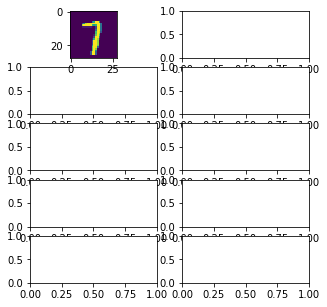